Use only with Megan's modifications to Tucker's dfmux_calc branch! dev_TJE_plus_spice
This branch assumes you have a number of bolometers = the number of bias frequencies to create a simulated comb. 
The current sharing is calculated for this comb, and then used to calculate the noise of N SQUIDs in combination with that comb. 

In [1]:
import dfmux_calc as d
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#define SQ parameters with spreads based on current SA13s, Zts scaled down to litebird appropriate size

#number of SAA to draw
n = 100
#number of SQUIDs in array
nsq = 50
sratio = nsq/3*64
nsqratio = nsq/(6*64)

# SQUID
zt = np.random.normal(1650*sratio, 300*sratio, n)
rdyn = np.random.normal(520*sratio*2, 100*sratio*2, n)
nei  = np.random.normal(1e-12 / np.sqrt(nsqratio), 0.1e-12 / np.sqrt(nsqratio))

#more parameters with no spread
lin = 70e-9 * nsqratio


saa = d.squid(zt,                                         #Transimpedence [Ohms]
                   rdyn,                                      #Dynamic impedence [Ohms]
                   nei,                                    #NEI [A/rtHz] (just a numer that makes sense from Tucker's results)
                   lin,                                    #Input inductance [H]
                   n_series=50,n_parallel=1,power=25e-9,  #array size and power dissipation 
                   snubber=5,                                #if there is a snubber on the input
                   t=0.3)                                     #what temperature the SAA is at [K]

In [3]:
#Wiring harness properties
wh = d.wire(30,                                #resistance [Ohms]
                40e-12,                        #capacitance [F] (this is the important one)
                0.75e-6,                       #inductance  [H]
                rshunt=False, cshunt=False)    #if theres any resistive or capcitive shunts across the output of the SAA
#Other parasitics
stripline = 60e-12 #assumed stripline inductance
cgnd = 0.7e-12  #assumed parasitic capacitance to ground
para = d.parasitics(stripline,cgnd,0) #stripline inductance[H], parasitic capacitance to ground[F] and R48 [Ohms]


In [4]:
#bolometer parameters and spreads
#draw one version of a comb of 68 bolos that gets used for all SQUIDs, CSF only gets calculated once
n=68
rbolo  = np.random.normal(0.7, 0.05, n)
rstray  = np.abs(np.random.normal(0.1, 0.05, n))
# stdevs?

#bolometer properties
bolo = d.bolo(rbolo,                   #operating impedence [Ohms] this is ignored in litebird.py
                  10,                #loopgain 
                  rstray,               #stray impedence [Ohms] this is ignored in litebird.py
                  2.5 * 0.24187821,  #psat - this is ignored in litebird.py,
                  0.24187821,
                  0.171,0.1)         #Tc and Tb [K]

In [5]:
bias_f = np.linspace(1.5e6,5.5e6,68)

nuller_cold = True #if the nuller resistors are at 4K or 300K
csf_factor = False #if you want to assume the CSF is of by x factor

dfm = d.dfmux_noise(saa,bolo,wh,para,nuller_cold=nuller_cold)
dfm.init_freq(bias_f,skip_spice=False)

Text(0.5, 1.0, 'Noise of 100 SQ vs bias freq')

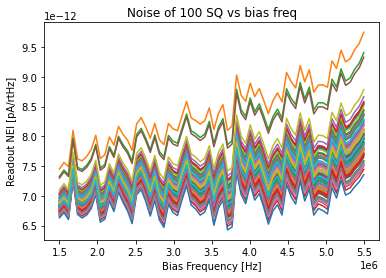

In [6]:
for i in range(100):
    plt.plot(bias_f,dfm.total[i])
plt.xlabel('Bias Frequency [Hz]')
plt.ylabel('Readout NEI [pA/rtHz]')
plt.title('Noise of 100 SQ vs bias freq')

Text(0.5, 1.0, 'Estimated noise for 100 SAA w/68 ch each')

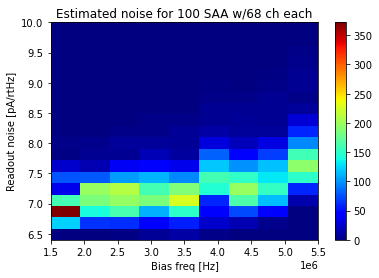

In [7]:

plt.hist2d(np.array([bias_f for i in range(100)]).flatten(),   dfm.total.flatten()*1e12,
           bins=[np.linspace(1.5e6,5.5e6,10),  np.linspace(6.4,10,20)],
           cmap='jet')
plt.xlabel('Bias freq [Hz]')
plt.colorbar()
plt.ylabel('Readout noise [pA/rtHz]')
plt.title('Estimated noise for 100 SAA w/68 ch each')

In [8]:
d.make_PDF_for_bolocalc(dfm,'testpdf.csv')

And above finally outputting a CSV of the PDF that can be used with BoloCalc